In [1]:
#Alex Butler 21338787
#code executes to the end without error
#refrences:
  #why normalise pixels https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)
  #how to show feature maps https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
  #started with W4 lab ex1 for CNN https://learn.ul.ie/d2l/le/lessons/45660/topics/820797

In [2]:
#get the packages
!pip install pandas
!pip install -q kaggle
!pip install tensorflow
!pip install keras
!pip install seaborn

In [3]:
!kaggle datasets download andrewmvd/animal-faces
!unzip /content/animal-faces.zip -d /content/animal-faces

Streaming output truncated to the last 5000 lines.
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001378.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001379.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001380.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001381.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001382.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001384.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001385.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001386.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001387.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001388.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001389.jpg  
  inflating: /content/animal-faces/afhq/train/wild/flickr_wild_001390.jpg  
  inflating: /content/animal-faces/af

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [21]:
BATCH_SZ = 64 #both higher and lower causes overfitting
#lower image resolution to speed up training, og is 512
IMG_SZ = 100#best trade off between speed and performance
IMG_SHAPE = (IMG_SZ,IMG_SZ)
#over 18 overfitting rises for smaller cardinalitys
#gains level off around 8 but accuracy and loss slowly rize afterward for bigger
# cardinalities, accuracy starts going down for val and test after 10
EPOCHS =8
epochs_r = range(1, EPOCHS + 1)#for graphing puroses
train_card = 180



> This dataset, also known as Animal Faces-HQ (AFHQ), consists of 16,130 high-quality images at 512×512 resolution. There are three domains of classes, each providing about 5000 images. By having multiple (three) domains and diverse images of various breeds per each domain, AFHQ sets a challenging image-to-image translation problem. The classes are: Cat, Dog, and Wildlife.

large(not all will be used), 3 class dataset. animal faces are very complex; the data is non-linear. data shuffeld to reduce bias. Shrink image size to 100x100 to improve performance, any lower and perfomance degrades




In [22]:
train_src = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/animal-faces/afhq/train',
    image_size=IMG_SHAPE,
    batch_size=BATCH_SZ,
    label_mode='categorical',
    shuffle=True,#randomize so results arn't effected by pic order
    #rgb outperforms greyscale massivley,
    #got 0 correct dog classifications on one greyscale test
    #in others(overly complex model struct) it just converged slower to the upper 90s
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/animal-faces/afhq/val',
    image_size=IMG_SHAPE,
    batch_size=BATCH_SZ,
    label_mode='categorical',
    shuffle=True,
)
print(train_src.cardinality())
print(val.cardinality())

Found 14630 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
tf.Tensor(229, shape=(), dtype=int64)
tf.Tensor(24, shape=(), dtype=int64)


normilzing to [0-1] is better because the smaller values are more suited to activation functions (https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)
Dataset is very large and thus takes a long time to train, shrink it (180 still gives great performance in resonable time), take the extras and turn it into a test set

In [23]:
#normalizeing image pixels to [0,1] improved train accuracy & percision from by .1
def normalize_img_pxs(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

#shrink datatset so epochs are a more resonable length
train = train_src.take(train_card)
print(train.cardinality())

#take the unused data from train
#and use it to create a test set
#skip over the data used for training so there is no overlap
test = train_src.skip(train_card).take(24)

train = train.map(normalize_img_pxs)
val = val.map(normalize_img_pxs)
test = test.map(normalize_img_pxs)


print(val.cardinality())
print(test.cardinality())
print(train.cardinality())

tf.Tensor(180, shape=(), dtype=int64)
tf.Tensor(24, shape=(), dtype=int64)
tf.Tensor(24, shape=(), dtype=int64)
tf.Tensor(180, shape=(), dtype=int64)


show the images to make sure preprocessing worked correctly and just to demonstrate the task being completed

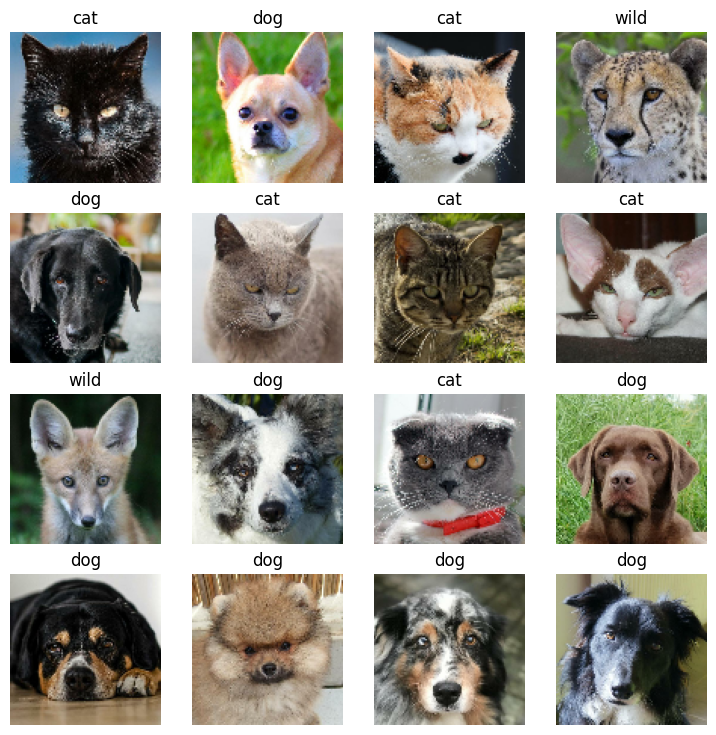

In [24]:
class_names = ['cat','dog','wild']

plt.figure(figsize=(9, 9))#size of the white background
#get the data in a convienet format even though its more than i need
for images, labels in train.take(1):#this only "loops" for 1 itr
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    #labels are stored as float of probabiliy that image is of a class
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()


original suffers from overfiting, training was .98 (for full size dataset) test is .91

In [25]:
# Define the CNN model
# Started with the cnn from lab4
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SZ, IMG_SZ, 3)))
model.add(layers.BatchNormalization())#batch normalize to reduce overfitting improved test acc by .03
#adding more batch normalization caused higher loss without improving plateu
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))#more conv and pooling improves test acc by .02
model.add(layers.MaxPooling2D((2, 2)))
#layer caused significant improvement in convergence speed and reduced overfitting by .03
model.add(layers.Dense(125, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_1 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                      

In [26]:
#adamw improved test accuracy over adam by .02 as it reduces overfitting
model.compile(optimizer=tf.keras.optimizers.AdamW(),
              #better than SGD for multi class problems
              loss='categorical_crossentropy',
              #add persision for more info
              metrics=['accuracy','Precision'])

In [27]:
#speed up use of dataset by prefetching
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
history = model.fit(train, epochs=EPOCHS, validation_data=val)
#converges quicky, somwhat overfitting

Epoch 1/8
180/180 [==============================] - 32s 172ms/step - loss: 0.5108 - accuracy: 0.8080 - precision: 0.8469 - val_loss: 0.8108 - val_accuracy: 0.7207 - val_precision: 0.9468
Epoch 2/8
180/180 [==============================] - 31s 170ms/step - loss: 0.1683 - accuracy: 0.9376 - precision: 0.9422 - val_loss: 0.4593 - val_accuracy: 0.7967 - val_precision: 0.8244
Epoch 3/8
180/180 [==============================] - 31s 169ms/step - loss: 0.1040 - accuracy: 0.9630 - precision: 0.9652 - val_loss: 0.1348 - val_accuracy: 0.9600 - val_precision: 0.9654
Epoch 4/8
180/180 [==============================] - 31s 170ms/step - loss: 0.0764 - accuracy: 0.9730 - precision: 0.9747 - val_loss: 0.1044 - val_accuracy: 0.9647 - val_precision: 0.9666
Epoch 5/8
180/180 [==============================] - 31s 169ms/step - loss: 0.0568 - accuracy: 0.9794 - precision: 0.9804 - val_loss: 0.0862 - val_accuracy: 0.9693 - val_precision: 0.9726
Epoch 6/8
180/180 [==============================] - 31s 170

In [29]:
#print trian vs test stats
test_loss, test_acc, test_precision = model.evaluate(test, verbose=3)
print('Test:')
print('\nTest accuracy:', test_acc)
print('\nTest precision:', test_precision)
print('\nTest loss:', test_loss)

print('\nTrain:')
print('\nTrain accuracy:', history.history['accuracy'][EPOCHS-1])
#if on TPU 'precision' if on CPU 'Precision' idk why
print('\nTrain precision:', history.history['precision'][EPOCHS-1])
print('\nTrain loss:', history.history['loss'][EPOCHS-1])


print('\nOverfit:')
#print the gap between trian and test
print('\naccuracy overfit:', history.history['accuracy'][EPOCHS-1] - test_acc)
print('\nprecision overfit:', history.history['precision'][EPOCHS-1] - test_precision)

Test:

Test accuracy: 0.98046875

Test precision: 0.98046875

Test loss: 0.056440338492393494

Train:

Train accuracy: 0.9862847328186035

Train precision: 0.9867860674858093

Train loss: 0.04356834664940834

Overfit:

accuracy overfit: 0.005815982818603516

precision overfit: 0.006317317485809326


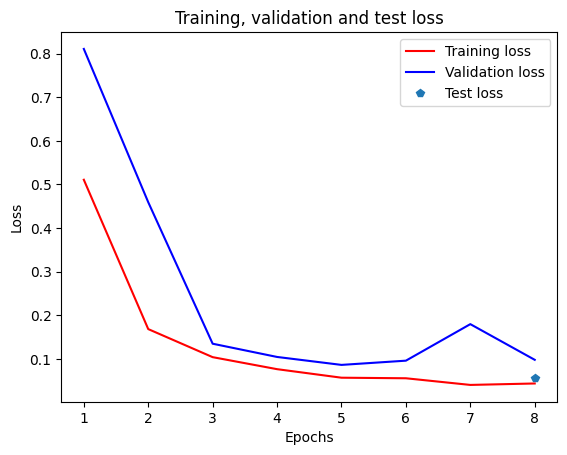

In [30]:
#plot losses
plt.plot(epochs_r, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs_r, history.history['val_loss'], 'b', label='Validation loss')
plt.plot(EPOCHS, test_loss, 'p', label='Test loss')
plt.title('Training, validation and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

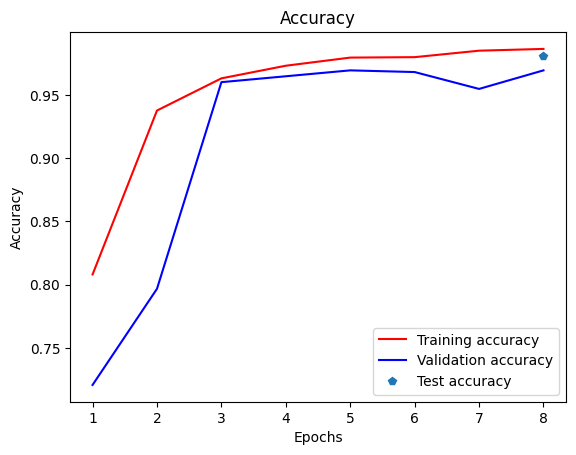

In [31]:
#plot accuracies
plt.plot(epochs_r, history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(epochs_r, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.plot(EPOCHS, test_acc, 'p', label='Test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

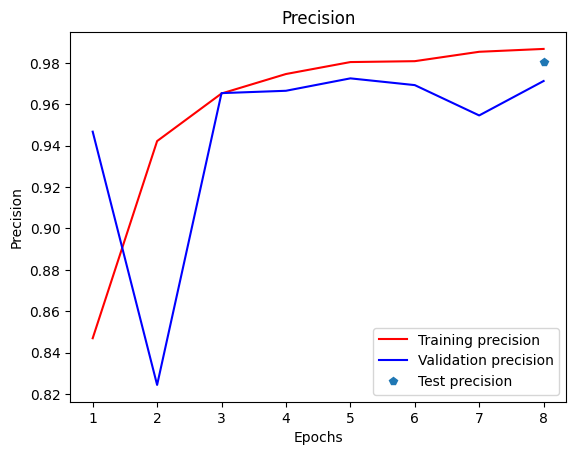

In [32]:
#plot precisions
plt.plot(epochs_r, history.history['precision'], 'r', label='Training precision')
plt.plot(epochs_r, history.history['val_precision'], 'b', label='Validation precision')
plt.plot(EPOCHS, test_acc, 'p', label='Test precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

1/1 [==============================] - 0s 46ms/step


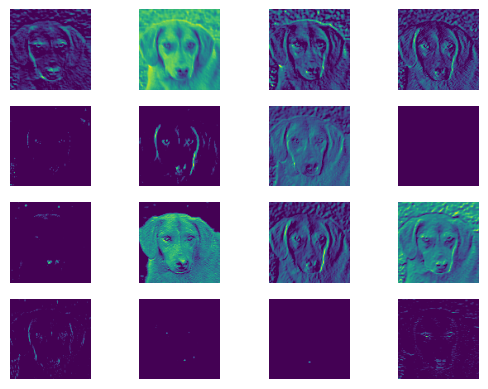

1/1 [==============================] - 0s 62ms/step


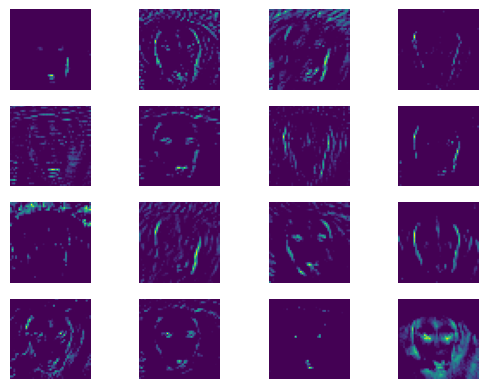

1/1 [==============================] - 0s 72ms/step


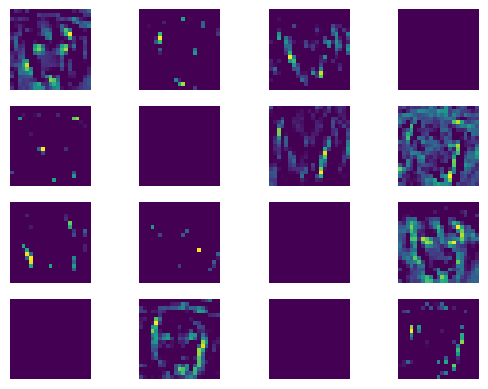

In [33]:
#based on https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
#show the feature maps produces by convolutional layers
# get the outputs of convolutional layers in the model
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
image_to_fm = None
#pick an image to show feature maps of
for images, labels in train.take(1):
  #cast to match the input shape of the cnn bc it expects to be reciving a batch
  image_to_fm = images[0].numpy().reshape(1, IMG_SZ, IMG_SZ, 3)

for out_layer in layer_outputs:
  feature_map_model = models.Model(inputs=model.inputs, outputs=out_layer)
  feature_maps = feature_map_model.predict(image_to_fm)

  # plot 16 of the feature maps for each convlutional layer
  square = 4
  fm_i = 1
  for _ in range(square):
    for _ in range(square):
      #put the image on the graph as a sublot
      plt.subplot(square, square, fm_i)
      plt.imshow(feature_maps[0, :, :, fm_i-1])
      fm_i += 1
      plt.axis("off")
    # show the figure
  plt.show()

1/1 [==============================] - 0s 29ms/step


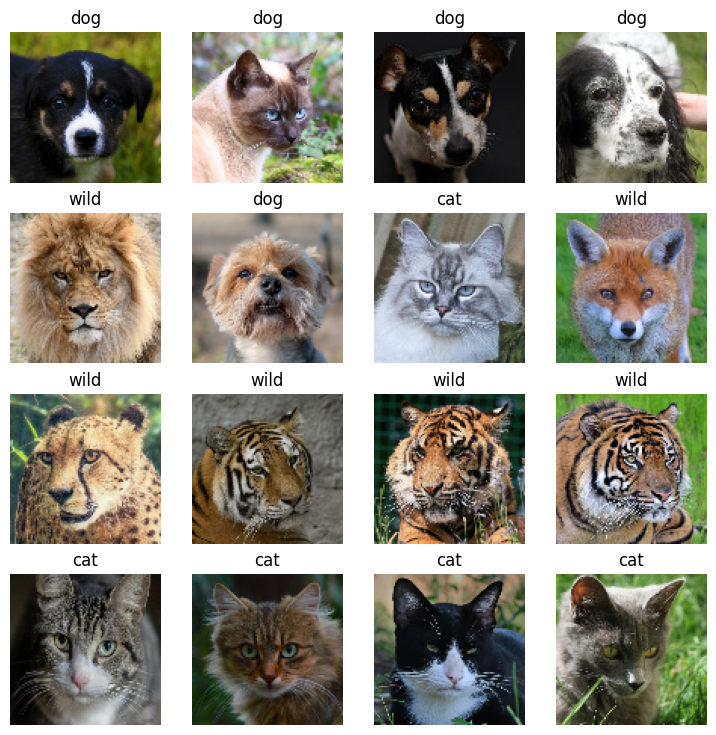

In [34]:
#same visualizeation as before training above but with predicted labels shown
#rather than the true labes in the dataset
plt.figure(figsize=(9, 9))
for images, labels in test.take(1):
  for i in range(16):
    #put the image on the graph as a sublot
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])

    #cast to match the input shape of the cnn bc it expects to be reciving a batch
    image = images[i].numpy().reshape(1, IMG_SZ, IMG_SZ, 3)

    y_pred = model.predict(image)
    predicted_class_index = np.argmax(y_pred, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    plt.title(predicted_class_name)
    plt.axis("off")

plt.show()

In [35]:
#make the calculations for the confusion matrix
y_true_classes = []
y_pred_classes = []
for images, labels in test:
    y_pred = model.predict(images)#make the prediction
    #y pred is 3 floats representing how likley the model thinks it is to be each class
    predicted_class_indices = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_names[name_i] for name_i in predicted_class_indices]
    y_pred_classes.extend(predicted_class_names)

    true_class_indices = np.argmax(labels, axis=1)
    true_class_names = [class_names[name_i] for name_i in true_class_indices]
    y_true_classes.extend(true_class_names)

print(y_true_classes)
print(y_pred_classes)
print(test.cardinality())

2/2 [==============================] - 0s 22ms/step
['cat', 'dog', 'wild', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'wild', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'wild', 'cat', 'dog', 'wild', 'wild', 'dog', 'wild', 'wild', 'dog', 'wild', 'cat', 'dog', 'wild', 'wild', 'cat', 'wild', 'dog', 'cat', 'wild', 'cat', 'dog', 'dog', 'dog', 'wild', 'wild', 'dog', 'dog', 'wild', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'wild', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'wild', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'wild', 'cat', 'dog', 'dog', 'dog', 'wild', 'wild', 'wild', 'dog', 'wild', 'cat', 'dog', 'wild', 'cat', 'wild', 'wild', 'wild', 'dog', 'dog', 'cat', 'dog', 'wild', 'cat', 'dog', 'wild', 'dog', 'cat', 'cat', 'dog', 'wild', 'dog', 'dog', 'dog', 'wild', 'wild', 'wild', 'wild', 'cat', 'cat', 'cat', 'wild', 'wild', 'dog', 'wild', 'wild', 'dog', 'wild', 'cat', 'cat', 'dog',

accuracy and percision are high, some overfitting, will usually have 1 error/pair of errors be more common e.g. mistaking wild for dog and vica versa

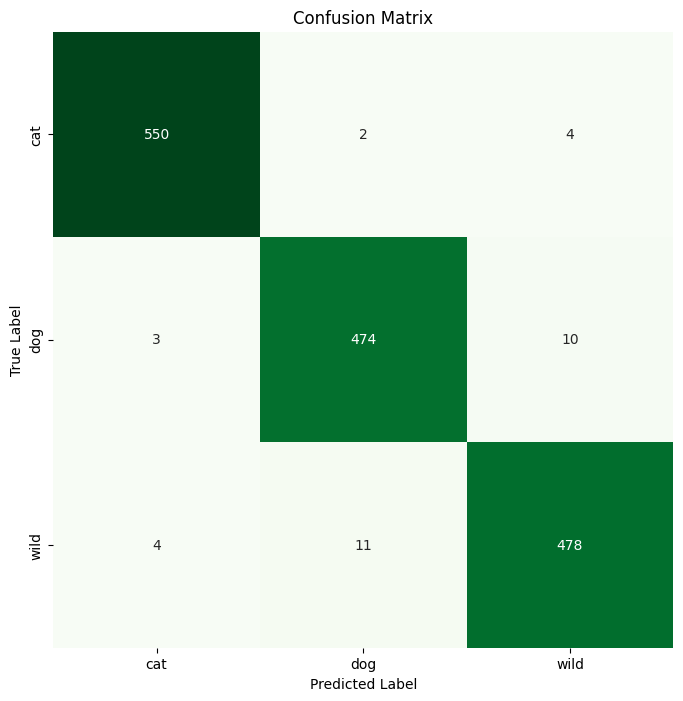

In [36]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
